### Model 3: Text Clustering 

Reference doc: 
- https://kavita-ganesan.com/python-keyword-extraction/
- https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/notebook#Credits,-Genres-and-Keywords-Based-Recommender
- https://www.kaggle.com/code/akshatpathak/text-data-clustering



In [160]:
import pandas as pd
import ast
import numpy as np
import regex as re
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


pd.set_option("display.max_columns", 85)
pd.set_option("display.max_rows", 85)
df = pd.read_csv('../../edit_data/cleaned_data/movies_main.csv')  
print(df.shape)

## Data will contain all movie_meta data + keywords. 

(45433, 19)


### Step 1: Text Pre-Processing
Extract text string from the meta data file (Tagline, Overview, Keywords) using REGEX and ast. 

Then, join all text into one series ['Joined_Strings'] (this is our feature for prediction).


Using REGEX to clean ['Overview'] and ['Tagline']

In [161]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Assuming 'stops' contains a set of stopwords
stops = set(stopwords.words('english'))

def pre_process(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'^\W+|\W+$', ' ', text)  # Remove leading/trailing non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Remove non-alphanumeric characters except spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stops]  # Remove stopwords
    return ''.join(tokens)  # Join tokens back into a single string

# Apply the function to both 'Tagline' and 'Overview' columns, handling NaN values
df['Cleaned_Tagline'] = df['Tagline'].apply(lambda x: pre_process(x) if pd.notna(x) else '')
df['Cleaned_Overview'] = df['Overview'].apply(lambda x: pre_process(x) if pd.notna(x) else '')

# Combine the cleaned 'Tagline' and 'Overview' into a single column 'Cleaned_Text'
df['Cleaned_Text'] = df['Cleaned_Tagline'] + ' ' + df['Cleaned_Overview']

# Optionally drop the intermediate columns if no longer needed
df.drop(columns=['Cleaned_Tagline', 'Cleaned_Overview'], inplace=True)

# View the resulting dataframe
df[['Tagline', 'Overview', 'Cleaned_Text']].head()

,Tagline,Overview,Cleaned_Text
0,NaN,"Led by Woody, Andy's toys live happily in his ...",led by woody andy s toys live happily in his...
1,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,roll the dice and unleash the excitement when...
2,Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,still yelling still fighting still ready for...
3,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...",friends are the people who let you be yourself...
4,Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,just when his world is back to normal he s ...


Parse ['keywords'] and join with the rest of the texts. 

In [162]:
###  parse and extract "name" in Keywords and then join them as one single string before text extraction
###  new series ['Joined_String]

# Function to process each row
def extract_from_list(row):
    try:
        # Convert the string representation of the list to an actual list
        list_of_dicts = ast.literal_eval(row)
        # Extract the 'name' from each dictionary and join them with a space
        return " ".join([d['name'] for d in list_of_dicts])
    except (ValueError, SyntaxError):
        return np.nan

# Apply the function to each row in your data
df['Cleaned_Keywords'] = [extract_from_list(row) for row in df['Keywords']]

# Combined cleaned tagline + overview together with keywords
df['Joined_Strings'] = df['Cleaned_Text'] + ' ' + df['Cleaned_Keywords']

df['Joined_Strings'].head()


0     led by woody  andy s toys live happily in his...
1    roll the dice and unleash the excitement  when...
2    still yelling  still fighting  still ready for...
3    friends are the people who let you be yourself...
4    just when his world is back to normal    he s ...
Name: Joined_Strings, dtype: object

### Step 2: Extract Keywords

Transform the feature ['Joined_Strings'] using TF-IDF to extract useful text. 

In [189]:
# convert dtype to unicode
documents = df['Joined_Strings'].values.astype("U")

## optional to create your own custom stop_words (to remove words such as "life","man","woman")
## limit to 10000 vocabulary for clustering
## ignore words appear over 90% in the doc
## ngram -> includes uni- and bigram words (eg: killer, serial killer)
vectorizer = TfidfVectorizer(max_df=0.90,stop_words='english', ngram_range=(1,2), max_features=10000)  

features = vectorizer.fit_transform(documents) #this is X

#check the shape of the data
features.shape

(45433, 10000)

In [191]:
#check the sample 50 vocabularies
list(vectorizer.vocabulary_.keys())[:10]

['led',
 'woody',
 'andy',
 'toys',
 'live',
 'happily',
 'room',
 'birthday',
 'brings',
 'buzz']

### Step 3: Cluster analysis with K-means

Use K-Means method to create cluster based on the transformed feature. Be sure to use the Silhouette score or Elbow test to check the optimal K-value. 

In [192]:
# we use K=11 based on silhoutte plot

k = 12
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=12, n_init=1)

In [193]:
# add/update cluster number after the fit. 
df['cluster'] = model.labels_

In [194]:
print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names_out()

for i in range(k):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :10]: #print out 10 feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')

Cluster centroids: 

Cluster 0:
 war
 world war
 war ii
 ii
 world
 german
 civil war
 civil
 soldier
 army
------------
Cluster 1:
 love
 falls
 falls love
 life
 story
 young
 woman
 man
 girl
 film
------------
Cluster 2:
 family
 town
 small
 small town
 home
 life
 father
 mother
 brother
 new
------------
Cluster 3:
 murder
 police
 killer
 detective
 serial
 serial killer
 cop
 crime
 investigation
 man
------------
Cluster 4:
 school
 high school
 high
 teacher
 student
 students
 girls
 girl
 teenager
 school student
------------
Cluster 5:
 man
 young
 father
 life
 old
 mother
 son
 wife
 woman
 relationship
------------
Cluster 6:
 woman director
 director
 woman
 life
 film
 young
 family
 documentary
 love
 story
------------
Cluster 7:
 music
 musical
 rock
 band
 film
 concert
 play
 singer
 punk
 documentary
------------
Cluster 8:
 movie
 film
 tv
 road
 life
 erotic
 road movie
 star
 hollywood
 tv movie
------------
Cluster 9:
 gang
 martial
 martial arts
 arts
 fu


In [195]:
## Distribution of clusters
df['cluster'].value_counts()


cluster
10    19522
5      7247
1      3129
2      2893
3      2726
6      2247
8      1479
7      1335
0      1332
11     1329
4      1209
9       985
Name: count, dtype: int64

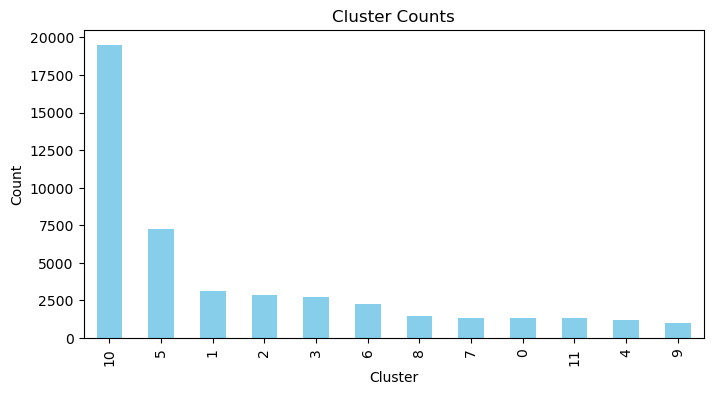

In [196]:
import matplotlib.pyplot as plt

# Plotting the Series as a bar chart
plt.figure(figsize=(8, 4))
df['cluster'].value_counts().plot(kind='bar', color='skyblue')

# Adding title and labels
plt.title('Cluster Counts')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Display the plot
plt.show()

Check Number of Cluster (K) with Silhouette Method.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.4504666294372765
For n_clusters = 9 The average silhouette_score is : 0.33498988186978584


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 11 The average silhouette_score is : 0.3283894338895205


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 15 The average silhouette_score is : 0.36354438907084297


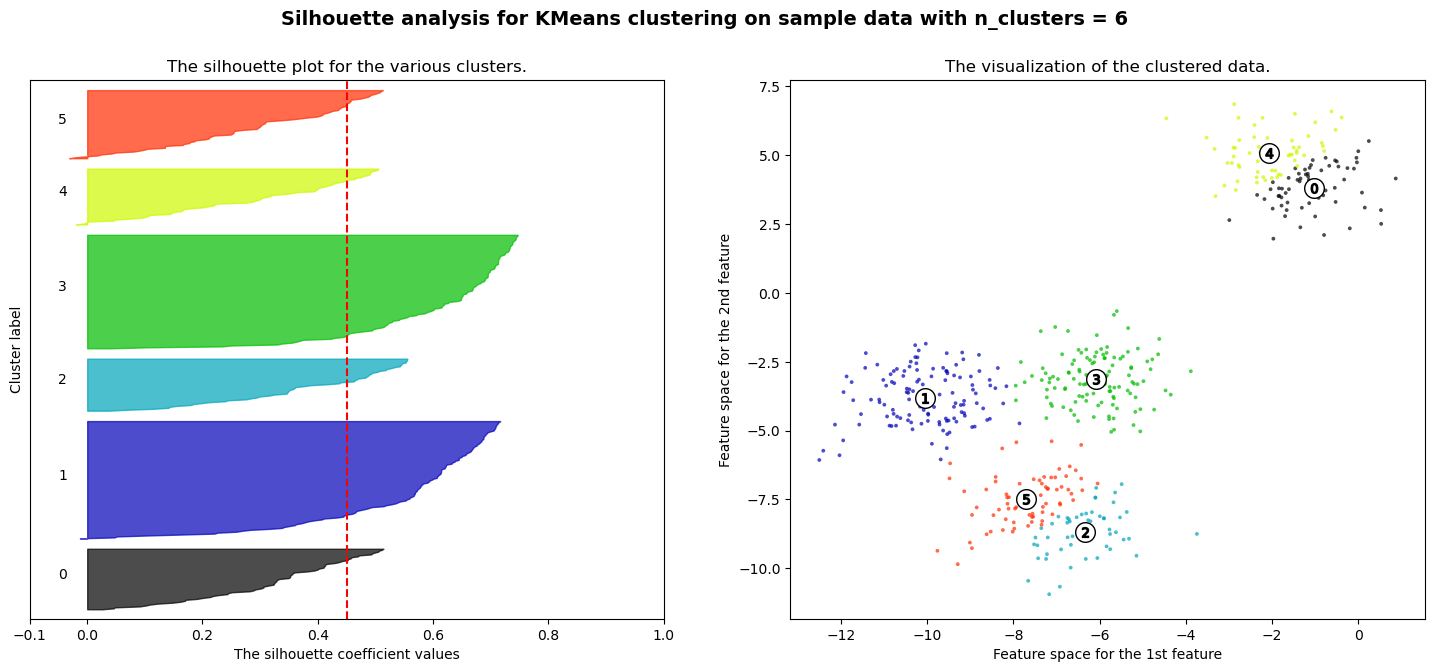

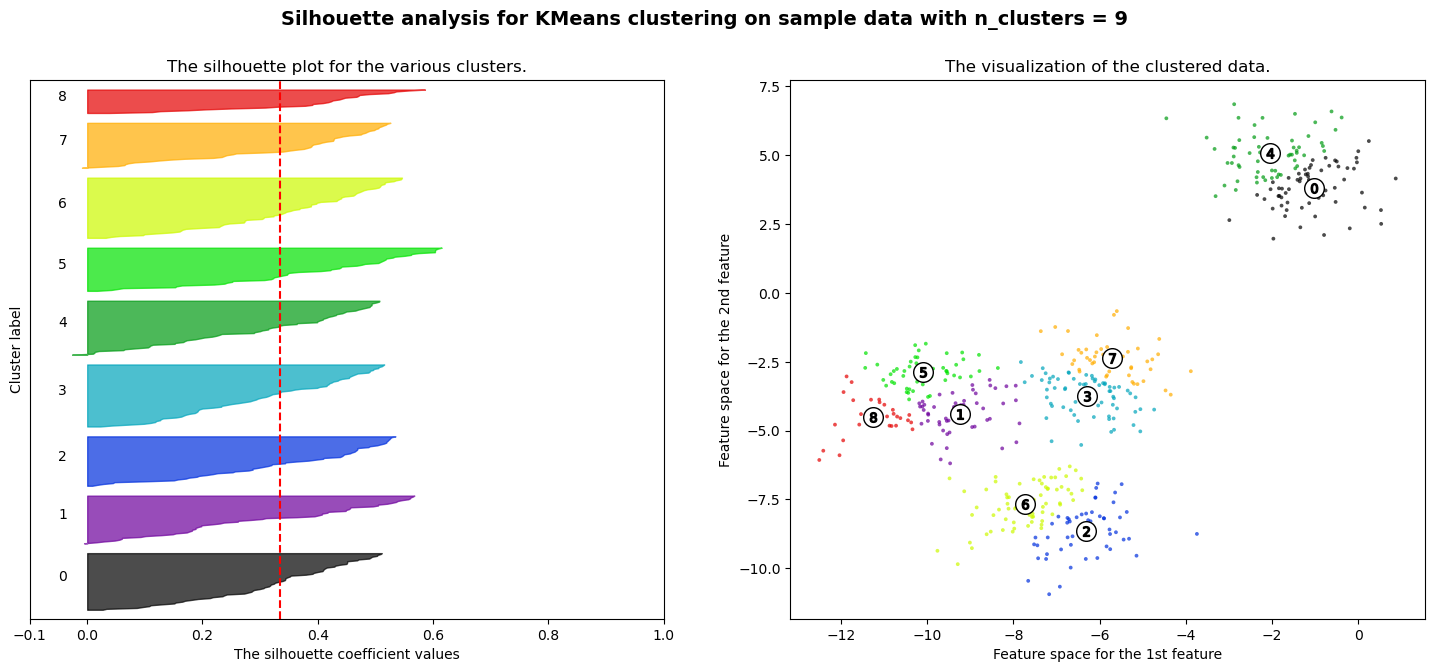

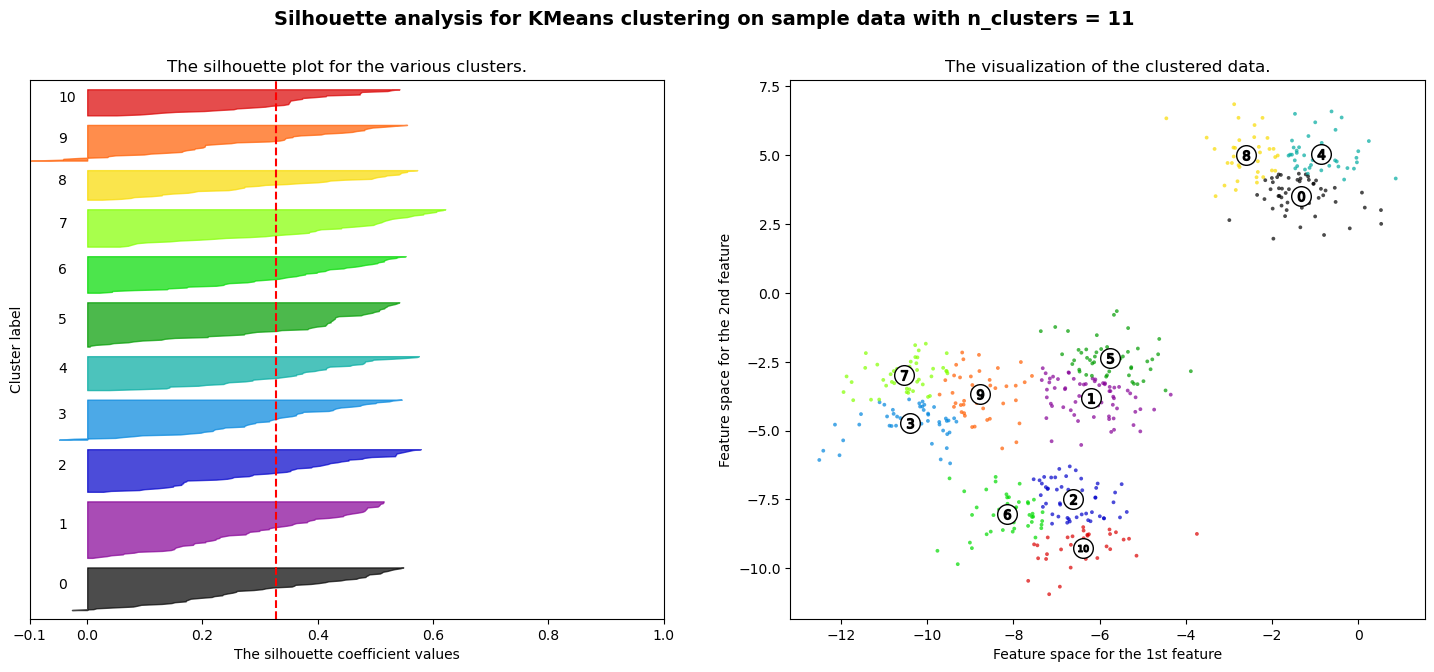

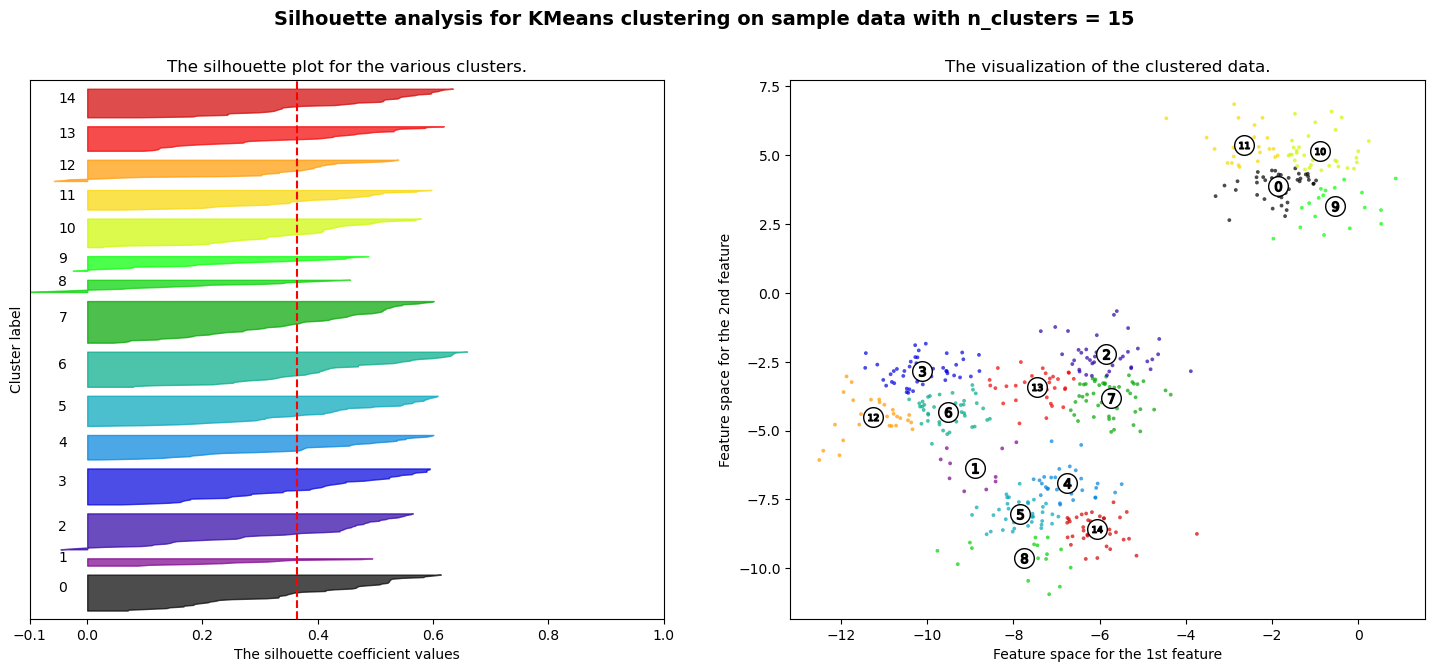

In [197]:

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [6,9,11,15]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Check Number (K) with Elbow Method:

Fitting for 5 clusters
Fitting for 6 clusters
Fitting for 7 clusters
Fitting for 8 clusters
Fitting for 9 clusters
Fitting for 10 clusters
Fitting for 11 clusters
Fitting for 12 clusters
Fitting for 13 clusters
Fitting for 14 clusters


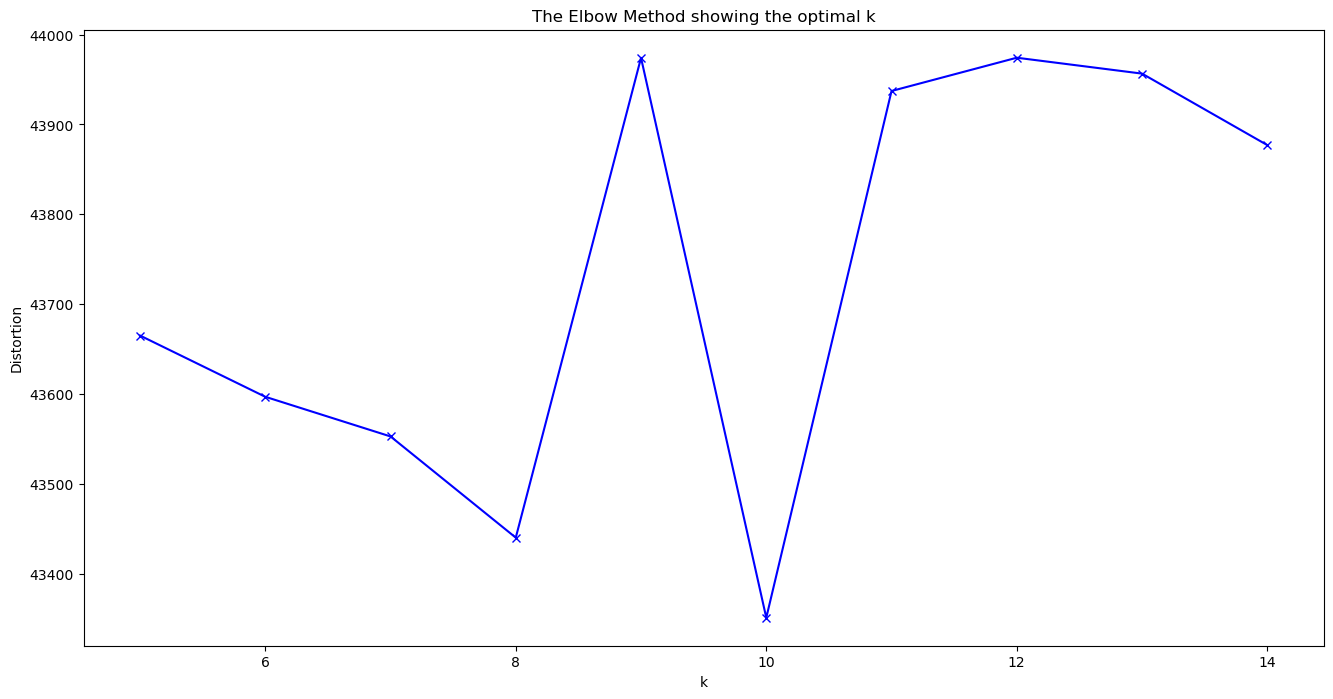

In [198]:
# plot the distortions based on a range of K value

distortions = []
ch_index = []
K = range(5,15)
for k in K:
    print("Fitting for " + str(k) + " clusters")
    kmeanModel = KMeans(n_clusters = k, init='k-means++', max_iter = 100, n_init = 1)
    kmeanModel.fit(features)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


#### Optimal k Value:
- Elbow method suggests: K=11
- Silhouette method suggests: between 10 to 15


### Step 4: Create KNN Classifier model

Create a KNN classifier, do a test-train split and fit the knn model. Calculate the KNN-score to evaluate. 
- X = features (based on keywords)
- y = cluster

In [199]:
## Create the Training and Test set
#  plotting a scatter matrix
#  75 (training)/25 (test) is the default for train_test_split

X = features #this is the vectorized text from keywords
y = df['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [200]:
# Drop lines of movie that has NaN Keywords in Cluster 0.
df = df.loc[~df['Joined_Strings'].isna() == True].copy()

In [146]:
## Remove rows with missing data
filt = (df['Keywords']=="[]")
df = df.loc[~filt]

In [201]:
print(X_train.shape)  # Should output (45433, n_features) where n_features is the number of features.
print(y_train.shape)  # Should output (45433,) if it's a 1D array.

(34074, 10000)
(34074,)


In [202]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

- the knn score was .96 when used only clean string set such as "keywords" as X. 
- with more NLP text joined as X, the lower the accuracy score (went down to 0.45 - 0.52).

In [203]:
knn.score(X_test, y_test)

0.42855885201162075

In [204]:
## Parse Genre for display 

# Function to parse the string and extract 'name'
def extract_names(data_string):
    if pd.isna(data_string):
        return np.nan
    try:
        # Safely evaluate the string to a Python object
        data_object = ast.literal_eval(data_string)
        if isinstance(data_object, list):
            # Extract 'name' from each dictionary in the list
            names = [item['name'] for item in data_object]
            return names
        elif isinstance(data_object, dict):
            # Extract 'name' from the dictionary
            return [data_object.get('name', np.nan)]
    except (ValueError, SyntaxError):
        return np.nan
    
    
df['Genres_Parse'] = df['Genres'].apply(extract_names)

### Step 5 - Prediction based on keywords

Set up a keyword prediction based on keywords. The output will be top 5 movies that is in the cluster, ranked by Popularity. 


In [209]:
# test data 
new_keywords = ['small town','world war','serial killer']
X_new = vectorizer.transform(new_keywords)
predicted_cluster = knn.predict(X_new)

print("Predicted Clusters for new keywords:", predicted_cluster)


for i in range(len(predicted_cluster)):
    print("--------------------------------------")
    print("predict from keyword:", new_keywords[i])
    print("predicted cluster:", predicted_cluster[i])
    filt = (df['cluster'] == predicted_cluster[i])
    print(df.loc[filt][['Original_Title','cluster','Popularity','Genres_Parse']].sort_values('Popularity',ascending=False).head())

Predicted Clusters for new keywords: [2 0 3]
--------------------------------------
predict from keyword: small town
predicted cluster: 2
                            Original_Title  cluster  Popularity  \
830                          The Godfather        2   41.109264   
35858                        Me Before You        2   34.347590   
42707  Diary of a Wimpy Kid: The Long Haul        2   28.176992   
28586                            Furious 7        2   27.275687   
20357                           Dark Skies        2   26.972326   

                              Genres_Parse  
830                         [Drama, Crime]  
35858                     [Drama, Romance]  
42707                     [Comedy, Family]  
28586                             [Action]  
20357  [Science Fiction, Thriller, Horror]  
--------------------------------------
predict from keyword: world war
predicted cluster: 0
                              Original_Title  cluster  Popularity  \
33032                       